# EN605.617 Introduction to GPU programming: Final Project

## Yujiang Wu 04/30/2022

### The goal of this project is to call CUDA defined data preprocessing function from pytorch and compare its timing with data preprocessing directly implemented with pure pytorch

Set up environment

In [1]:
import torch
import numpy as np

Preparing the Dataset

In [2]:
def load_mnist(path, kind='train'):
    from numpy import fromfile, uint8
    import os
    import struct
    
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = fromfile(lbpath, dtype=uint8)
        with open(images_path, 'rb') as imgpath:
            magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
            images = fromfile(imgpath, dtype=uint8).reshape(len(labels), 784)
            #images = ((images / 255.) - .5) * 2
    return images, labels

In [3]:
X_train, y_train = load_mnist('../data', kind='train')
print(f'Rows= {X_train.shape[0]}, columns= {X_train.shape[1]}')

X_test, y_test = load_mnist('../data', kind='t10k')
print(f'Rows= {X_test.shape[0]}, columns= {X_test.shape[1]}')

Rows= 60000, columns= 784
Rows= 10000, columns= 784


The data is read in as numpy array. There are 60000 training samples and 10000 testing samples.

In [4]:
print(f'Xtrain:  data type= {type(X_train)}, data shape= {X_train.shape}, element type={X_train.dtype}')

print(f'ytrain:  data type= {type(y_train)}, data shape= {y_train.shape}, element type={y_train.dtype}')

print(f'Xtrain:  data type= {type(X_test)}, data shape= {X_test.shape}')

print(f'ytrain:  data type= {type(y_test)}, data shape= {y_test.shape}')

Xtrain:  data type= <class 'numpy.ndarray'>, data shape= (60000, 784), element type=uint8
ytrain:  data type= <class 'numpy.ndarray'>, data shape= (60000,), element type=uint8
Xtrain:  data type= <class 'numpy.ndarray'>, data shape= (10000, 784)
ytrain:  data type= <class 'numpy.ndarray'>, data shape= (10000,)


Convert the numpy array into tensor since we will be using pytorch

In [5]:
X_train_tensor_raw=torch.from_numpy(X_train).type(torch.float32)
y_train_tensor_raw=torch.from_numpy(y_train)
X_test_tensor_raw=torch.from_numpy(X_test).type(torch.float32)
y_test_tensor_raw=torch.from_numpy(y_test)

In [6]:
print(f'x_train_tensor:  data type= {type(X_train_tensor_raw)}, data shape= {X_train_tensor_raw.size()}, element type={X_train_tensor_raw.dtype}')
print(f'y_train_tensor:  data type= {type(y_train_tensor_raw)}, data shape= {y_train_tensor_raw.size()}, element type={y_train_tensor_raw.dtype}')
print(f'x_train_tensor:  data type= {type(X_test_tensor_raw)}, data shape=  {X_test_tensor_raw.size()}, element type={X_test_tensor_raw.dtype}')
print(f'y_train_tensor:  data type= {type(y_test_tensor_raw)}, data shape= {y_test_tensor_raw.size()}, element type={y_test_tensor_raw.dtype}')

x_train_tensor:  data type= <class 'torch.Tensor'>, data shape= torch.Size([60000, 784]), element type=torch.float32
y_train_tensor:  data type= <class 'torch.Tensor'>, data shape= torch.Size([60000]), element type=torch.uint8
x_train_tensor:  data type= <class 'torch.Tensor'>, data shape=  torch.Size([10000, 784]), element type=torch.float32
y_train_tensor:  data type= <class 'torch.Tensor'>, data shape= torch.Size([10000]), element type=torch.uint8


In [7]:
print(f'Xtrain:  Max= {np.amax(X_train)}, Min= {np.amin(X_train)},data type= {type(X_train)}')
print(f'X_train_tensor:  Max= {torch.max(X_train_tensor_raw)}, Min= {torch.min(X_train_tensor_raw)},data type= {type(X_train_tensor_raw)}')

Xtrain:  Max= 255, Min= 0,data type= <class 'numpy.ndarray'>
X_train_tensor:  Max= 255.0, Min= 0.0,data type= <class 'torch.Tensor'>


x_train_tensor contains 60000 training samples. Each sample is a flat vector containing 784 pixels. Each pixel is a number between 0 and 255. 
The data has to be preprocessed such that they are between -1 and 1. We have to do this operation 60000 times for the trainig set and another 10000 times for the testing set.
Thus, it is a perfect application for data parallelism on GPU using cuda.
Each cuda thread needs to perform
  x=max(min(((x/255.0)-0.5)*2,1),-1)

And We are going to write a custom CUDA kernel to do this task and call it in python using pytorch.

## Custom CUDA Function for image preprocessing

In [8]:
print(torch.__version__)

1.11.0+cu113


Now, it is time to write a custom CUDA Function for image preprocessing

Load our custome CUDA libary by JIT option

In [9]:
from torch.utils.cpp_extension import load
cuda_module = load(name="grayscaleimagenormalization",
                    extra_include_paths=["../include"],
                    sources=["grayscaleimagenormalization_ops.cpp", "../kernel/grayscaleimagenormalization_kernel.cu"],
                    verbose=False)

By default, these tensors are on the CPU, we use .to(device) to push it on to GPU

In [10]:
print(f'x_train_tensor:  device= {X_train_tensor_raw.device}')
print(f'y_train_tensor:  device= {y_train_tensor_raw.device}')
print(f'x_train_tensor:  device= {X_test_tensor_raw.device}')
print(f'y_train_tensor:  device= {y_test_tensor_raw.device}')

x_train_tensor:  device= cpu
y_train_tensor:  device= cpu
x_train_tensor:  device= cpu
y_train_tensor:  device= cpu


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
device

'cuda'

In [13]:
X_train_tensor_raw=X_train_tensor_raw.to('cpu')
X_test_tensor_raw=X_test_tensor_raw.to(device)

In [14]:
print(f'x_train_tensor:  device= {X_train_tensor_raw.device}')
print(f'X_test_tensor_raw:  device= {X_test_tensor_raw.device}')

x_train_tensor:  device= cpu
X_test_tensor_raw:  device= cuda:0


In [15]:
X_test_tensor_norm=torch.empty(X_test_tensor_raw.size(), dtype=X_test_tensor_raw.dtype,device=X_test_tensor_raw.device)

In [16]:
torch.numel(X_test_tensor_norm)

7840000

In [17]:
cuda_module.torch_launch_grayscaleimagenormalization(X_test_tensor_norm,X_test_tensor_raw, torch.numel(X_test_tensor_norm))

In [18]:
print(f'X_test_tensor_norm: Shape: ={X_test_tensor_norm.size()}, Max= {torch.max(X_test_tensor_norm)}, Min= {torch.min(X_test_tensor_norm)}')

X_test_tensor_norm: Shape: =torch.Size([10000, 784]), Max= 1.0, Min= -1.0


In [19]:
X_test_tensor_norm=X_test_tensor_norm.to("cpu")#push it back for plotting

View the last 6 samples in the normalized testing set

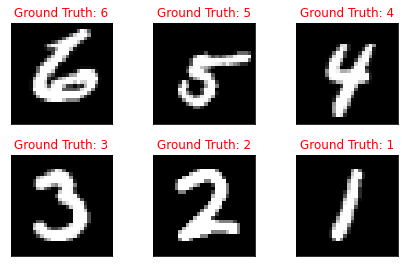

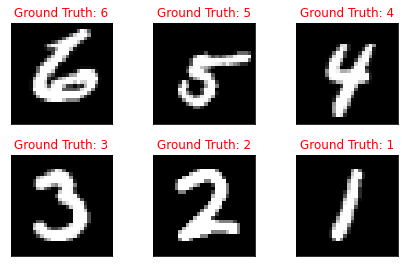

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(torch.reshape(X_test_tensor_norm[X_test_tensor_norm.size()[0]-1-i,:],(28,28)), cmap='gray', interpolation='none')
  title_obj =plt.title("Ground Truth: {}".format(y_test_tensor_raw[y_test_tensor_raw.size()[0]-1-i]))
  plt.setp(title_obj, color='r') 
  plt.xticks([])
  plt.yticks([])
fig


Now,we successfully 
1. wrote a kernel function in CUDA (grayscaleimagenormalization_kernel.cu)
2. wrote the host side caller (grayscaleimagenormalization_kernel.cu,launch_grayscaleimagenormalization.h)
3. wrote an python,C++ interfacing file (grayscaleimagenormalization_ops.cpp)
4. compiled our custom cuda_module using JIT option
5.  normalized the pixel of raw gray scale image,which is between [0,255], to a number between [-1,1]. 

##  Timing Comparison


let's package into a function that do the following things if GPU is availiable
1. set input tensor's device to cuda 
2. call custom kernel
3. set the result tensor's device back to cpu

And we want to time this code and comparing timing with the case where we just use the pure pytorch code to do the pixel normalization 

### Custom CUDA version 

In [22]:
def grayscaleimagenorm_cuda(origgrayimage):
  if torch.cuda.is_available():
    device='cuda'
    origgrayimage=origgrayimage.to(device)
    normgrayimage=origgrayimage
    cuda_module.torch_launch_grayscaleimagenormalization(normgrayimage,origgrayimage, torch.numel(origgrayimage))
    origgrayimage=origgrayimage.to('cpu')
    normgrayimage=normgrayimage.to('cpu')
    return normgrayimage
  else:
     print("GPU is not avaliable. Operation performed using CPU")
     normgrayimage=torch.clamp(((origgrayimage / 255.) - .5) * 2,min=-1.0,max=1.0)
     return normgrayimage

### Pure Pytorch tensor operates on CPU

In [23]:
def grayscaleimagenorm_cpu(origgrayimage):
  if origgrayimage.device.type == 'cpu':
    normgrayimage=torch.clamp(((origgrayimage / 255.) - .5) * 2,min=-1.0,max=1.0)
    return normgrayimage
  else:
     raise Exception("please pass in a tensor on the cpu")

### Pure Pytorch tensor operates on GPU

In [24]:
def grayscaleimagenorm_gputorch(origgrayimage):
  if torch.cuda.is_available():
    device='cuda'
    origgrayimage=origgrayimage.to(device)
    normgrayimage=torch.clamp(((origgrayimage / 255.) - .5) * 2,min=-1.0,max=1.0)
    origgrayimage=origgrayimage.to('cpu')
    normgrayimage=normgrayimage.to('cpu')
    return normgrayimage
  else:
     print("GPU is not avaliable. Operation performed using CPU")
     normgrayimage=torch.clamp(((origgrayimage / 255.) - .5) * 2,min=-1.0,max=1.0)
     return normgrayimage

In [25]:
def run_cuda():#function wrapper for testing custom CUDA
  grayscaleimagenorm_cuda(X_train_tensor_raw)

In [26]:
def run_torch_cpu():# function wrapper for testing pytorch cpu version
  grayscaleimagenorm_cpu(X_train_tensor_raw)

In [27]:
def run_torch_gpu():# function wrapper for testing pytorch gpu version
  grayscaleimagenorm_gputorch(X_train_tensor_raw)

Function that will help us time the GPU code correctly

In [28]:
def show_time(func,ntest):
    import time
    times = list()
    res = None
    # GPU warm up
    for _ in range(10):#this is only needed for JIT compilation
        res = func()
    for _ in range(ntest):
        # sync the threads to get accurate cuda running time
        torch.cuda.synchronize(device="cuda:0")
        start_time = time.time()
        func()
        torch.cuda.synchronize(device="cuda:0")
        end_time = time.time()
        times.append((end_time-start_time)*1e6)
    return times, res

In [29]:
print("Running cuda...")
cuda_time, cuda_res = show_time(run_cuda,10)
print("Cuda time:  {:.3f}us".format(np.mean(cuda_time)))

Running cuda...
Cuda time:  326589.227us


In [30]:
print("Running torch cpu...")
torch_time, torch_res = show_time(run_torch_cpu,10)
print("Torch time:  {:.3f}us".format(np.mean(torch_time)))


Running torch cpu...
Torch time:  276929.092us


In [31]:
print("Running torch gpu...")
torch_time, torch_res = show_time(run_torch_gpu,10)
print("Torch time:  {:.3f}us".format(np.mean(torch_time)))


Running torch gpu...
Torch time:  331928.658us


### Timing Conclusion: 

The amount of computation we make here does not justify the time spend on pushing data on/off the device. 

But our custom CUDA implemetation achieved similar level of performance as the pythorch GPU version

In [32]:
X_train_tensor_norm=grayscaleimagenorm_cuda(X_train_tensor_raw)

In [33]:
print(f'X_train_tensor_raw: Shape: ={X_train_tensor_raw.size()}, Max= {torch.max(X_train_tensor_raw)}, Min= {torch.min(X_train_tensor_raw)}')
print(f'X_train_tensor_norm: Shape: ={X_train_tensor_norm.size()}, Max= {torch.max(X_train_tensor_norm)}, Min= {torch.min(X_train_tensor_norm)}')

X_train_tensor_raw: Shape: =torch.Size([60000, 784]), Max= 255.0, Min= 0.0
X_train_tensor_norm: Shape: =torch.Size([60000, 784]), Max= 1.0, Min= -1.0


## Training NN using pytorch to recognize handwritten digits

This is the end of using custom CUDA kernel for data preprocessing.
In the following sessions of this notebook, we will train a NN using these proprocessed data.
For simplicity, we hereby rename them to shorter name.

In [34]:
X_train_tensor=X_train_tensor_norm
y_train_tensor=y_train_tensor_raw
X_test_tensor=X_test_tensor_norm
y_test_tensor=y_test_tensor_raw

Hyperparam setting

In [35]:
n_epochs = 3
batch_size_train = 600
batch_size_test = 100
learning_rate = 0.01
momentum = 0.5
log_interval = 20

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Use Pytorch's Dataset and Dataloader to manage things like minibatch

In [36]:
from torch.utils.data import Dataset
class CUSTOM_MINISTDataset(Dataset):
    def __init__(self, data, label):
      self.data=data
      self.label=label
    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      curr_data =self.data[idx, :]
      curr_label =self.label[idx]
      if(type(curr_data) == torch.Tensor and type(curr_label) == torch.Tensor):
        return {
          "data": curr_data,
          "label": curr_label,
        }
      else:
        return {
          "data": torch.tensor(curr_data,dtype=torch.float64),
          "label": torch.tensor(curr_label,dtype=torch.uint8),
        }

In [37]:
custom_traingdataset=CUSTOM_MINISTDataset(data=X_train_tensor,label=y_train_tensor)
custom_testdataset=CUSTOM_MINISTDataset(data=X_test_tensor,label=y_test_tensor)

In [40]:
#?torch.utils.data.DataLoader

In [38]:
from torch.utils.data import DataLoader
train_loader = DataLoader(custom_traingdataset,batch_size = batch_size_train, shuffle=True,num_workers=0)

In [39]:
test_loader = DataLoader(custom_testdataset,batch_size = batch_size_test, shuffle=True,num_workers=0)

Build Neural Network in Pytorch

In [40]:
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim as optim

In [41]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x,apply_softmax=False):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        if apply_softmax:
          x=F.softmax(x, dim=1)
        return x

In [42]:
network = NeuralNetwork()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [43]:
#https://discuss.pytorch.org/t/about-the-difference-between-none-and-sum-in-reduction-for-bceloss/53924
mean_loss = nn.CrossEntropyLoss(reduction='mean')   
sum_loss = nn.CrossEntropyLoss(reduction='sum')

Training the Model

In [44]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [45]:
def train(epoch):
  network.train()
  for batch_idx, sample  in enumerate(train_loader):
    data=sample['data']
    target=sample['label']
    optimizer.zero_grad()
    output = network(data)
    loss = mean_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [46]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for sample in test_loader:
      data=sample['data']
      target=sample['label']
      output = network(data)
      test_loss += sum_loss(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [47]:
test()


Test set: Avg. loss: 2.3166, Accuracy: 694/10000 (7%)



In [48]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322415
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.213693
Train Epoch: 1 [24000/60000 (40%)]	Loss: 2.088973
Train Epoch: 1 [36000/60000 (60%)]	Loss: 1.909328
Train Epoch: 1 [48000/60000 (80%)]	Loss: 1.688393

Test set: Avg. loss: 1.4151, Accuracy: 7390/10000 (74%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.460418
Train Epoch: 2 [12000/60000 (20%)]	Loss: 1.228157
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.989741
Train Epoch: 2 [36000/60000 (60%)]	Loss: 0.854296
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.760605

Test set: Avg. loss: 0.6637, Accuracy: 8495/10000 (85%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.704454
Train Epoch: 3 [12000/60000 (20%)]	Loss: 0.631328
Train Epoch: 3 [24000/60000 (40%)]	Loss: 0.596511
Train Epoch: 3 [36000/60000 (60%)]	Loss: 0.509396
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.521428

Test set: Avg. loss: 0.4796, Accuracy: 8758/10000 (88%)



Evaluating the Model's Performance

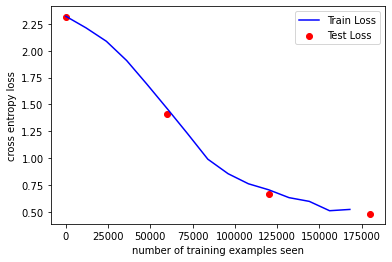

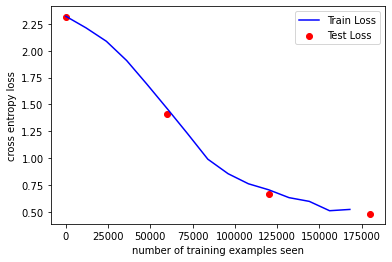

In [49]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross entropy loss')
fig

In [50]:
examples= enumerate(test_loader)
batch_idx, sample = next(examples)

In [51]:
sample['data'].shape

torch.Size([100, 784])

In [52]:
with torch.no_grad():
  output = network(sample['data'])

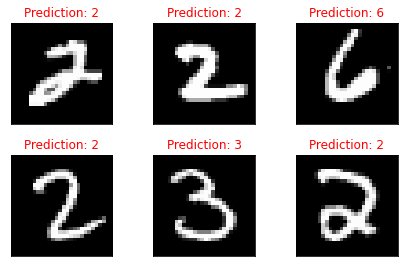

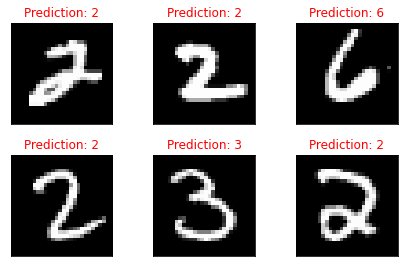

In [53]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(torch.reshape(sample['data'][i],(28,28)), cmap='gray', interpolation='none')
  title_obj=plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.setp(title_obj, color='r') 
  plt.xticks([])
  plt.yticks([])
fig

Continue Training from CheckPoints

In [54]:
continued_network = NeuralNetwork()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [55]:
network_state_dict = torch.load('./results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('./results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [56]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.534390
Train Epoch: 4 [12000/60000 (20%)]	Loss: 0.505384
Train Epoch: 4 [24000/60000 (40%)]	Loss: 0.449246
Train Epoch: 4 [36000/60000 (60%)]	Loss: 0.412770
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.399655

Test set: Avg. loss: 0.4093, Accuracy: 8870/10000 (89%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.380324
Train Epoch: 5 [12000/60000 (20%)]	Loss: 0.400777
Train Epoch: 5 [24000/60000 (40%)]	Loss: 0.412764
Train Epoch: 5 [36000/60000 (60%)]	Loss: 0.373909
Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.400338

Test set: Avg. loss: 0.3732, Accuracy: 8943/10000 (89%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.401716
Train Epoch: 6 [12000/60000 (20%)]	Loss: 0.435021
Train Epoch: 6 [24000/60000 (40%)]	Loss: 0.390530
Train Epoch: 6 [36000/60000 (60%)]	Loss: 0.341516
Train Epoch: 6 [48000/60000 (80%)]	Loss: 0.412198

Test set: Avg. loss: 0.3473, Accuracy: 9014/10000 (90%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.321503
Train Epoch: 7 [12000/60000 (20%)]	Loss: 0.375

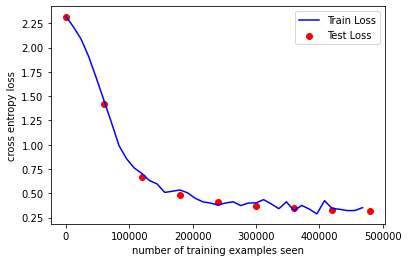

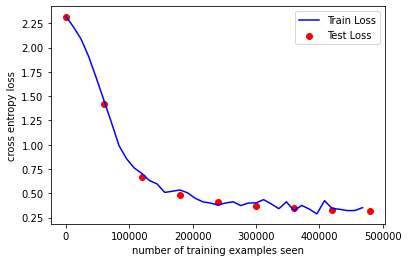

In [57]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross entropy loss')
fig


# Summary

Here, we reached the end of this project. 
As a summary, the following has been accumplished:
1. Implement a custom CUDA kernel that normlaize the pixels of a raw gray image
2. Implemented the host side caller that calls the kernel
3. Used pytorch backend ATen library to interface with our custome C++/CUDA code
4. Used pybind11 to create python bindings for our C++ code
5. Used Just in Time compilation option for load our custome defined libary
6. Performed image preprocessing by calling our custom CUDA module in python
7. Did a timing comparison among pytorch CPU version, pytorch GPU version, and CUDA version called in pytorch
8. Continued to train a Neural Network using pytorch based on the preprocessed data using our custom defined CUDA kernel

## Future work

With the infrastucture set up here, we could potentially do more interesting things using CUDA custom kernel.

For example, use NPP image processing library to rotate each picture a little bit to generate synthetic data.

Hint: A number 8 rotates by 3 degree is still a number 8.

## References:
* [CUSTOM CUDA Example](https://github.com/godweiyang/NN-CUDA-Example) 
* [CUSTOM C++ AND CUDA EXTENSIONS](https://pytorch.org/tutorials/advanced/cpp_extension.html)
* [MNIST Handwritten Digit Recognition in PyTorch](https://nextjournal.com/gkoehler/pytorch-mnist)
* [Neural network in CUDA/C++](https://github.com/BobMcDear/Neural-Network-CUDA)